# Introduction to Machine Learning in Python 4 - Deep Learning

We will do a deep down on two fronts:

1. [Error-based Machine Learning](#error)
2. [TensorFlow](#tf)

In [1]:
# import some basic libraries to do analysis and ML
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Visualization details
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 8,6

<a id="error"></a>

# Error-based Machine Learning

## Linear Regression

mpg ~ 46.32 -0.01*weight


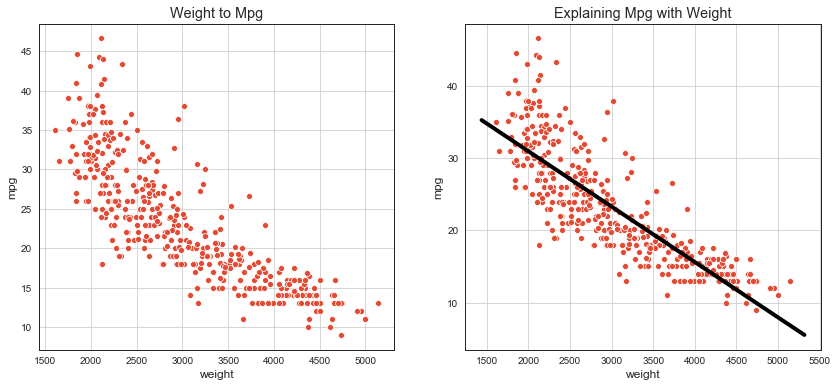

In [3]:
# scatter plot with fitted linear regression
df = pd.read_csv('./imlp4_files/auto-mpg.csv')

from sklearn.linear_model import LinearRegression

X = df['weight'].values.reshape(-1, 1)
Y = df['mpg'].values
lr = LinearRegression()
lr.fit(X, Y);

def abline(ax, slope, intercept):
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '-', c='black', lw='4')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6));
axx = sns.scatterplot(x='weight', y='mpg', data=df, ax=ax[0]);
axx.set_title('Weight to Mpg');
axx.grid();

axx = sns.scatterplot(x='weight', y='mpg', data=df, ax=ax[1]);
abline(axx, lr.coef_[0], lr.intercept_)
axx.set_title('Explaining Mpg with Weight');
axx.grid();

print(f'mpg ~ {lr.intercept_:.2f} {lr.coef_[0]:.2f}*weight')

## Linear Regression

$$ y = w_0 + w_1x_1 $$

Where

1. $y$ is value of target feature we want to explain (eg. car mpg)
1. $w_0$ is the bias (y-intercept) sometimes refered to as $w_0$
1. $w_1$ is the weight of feature 1
1. $x_1$ is dependent feature value (eg. car weight)

Previous model uses only one feature, a more sophisticated model might rely on multiple features each having its own weight.

$$ y = w_0x_0 + w_1x_1 + w_2x_2 + w_3x_3 $$

## Attribution

Following chapters are made according to/and from materials available in [Google - Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/ml-intro)

![course](./imlp4_files/crash.png)

## Training and Loss

In supervised setting, training a model means finding good values for all the weights from labeled instances.

*Loss* is the penalty for a bad prediction on a single instance.

![loss](./imlp4_files/loss.png)

### Error/Loss Functions

*Mean square error (MSE, $L_2$)* is the average squared loss per example over the whole dataset.

$$ \text{MSE} = \frac{1}{N} \sum_{(x, y) \in D}\left(y - \text{prediction}(x)\right)^2 $$

Where

1. $N$ is number of instances
2. $(x, y)$ is an example where $x$ are independent features, $y$ target feature
3. $\text{prediction}(x)$ is prediction of the model on instance $x$
4. $D$ is a data set containing many labeled examples

*Mean absolute error (MAE)* is the average absolute loss per example over the whole dataset.

$$ \text{MAE} = \frac{1}{N} \sum_{(x, y) \in D}|y - \text{prediction}(x)| $$

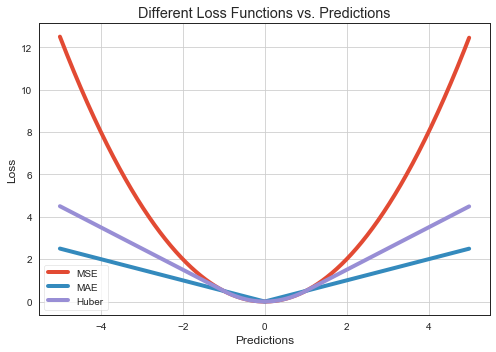

In [378]:
# MSE and MAE
def mse(true, pred):
    return np.sum((true - pred)**2) / 2

def mae(true, pred):
    return np.sum(np.abs(true - pred)) / 2

def huber(true, pred, delta):
    loss = np.where(np.abs(true-pred) < delta, 0.5*((true-pred)**2), delta*np.abs(true - pred) - 0.5*(delta**2))
    return np.sum(loss)

N = 1000
delta = 1
# array of same target value 10000 times
target = np.repeat(0, N) 
pred = np.arange(-5, 5, .01)

loss_mse = [mse(target[i], pred[i]) for i in range(N)]
loss_mae = [mae(target[i], pred[i]) for i in range(N)]
loss_huber = [huber(target[i], pred[i], delta) for i in range(N)]

fig, ax = plt.subplots(1,1, figsize = (7,5))
# plot 
ax.plot(pred, loss_mse, label='MSE', lw=4)
ax.plot(pred, loss_mae, label='MAE', lw=4)
ax.plot(pred, loss_huber, label='Huber', lw=4)
ax.set_xlabel('Predictions')
ax.set_ylabel('Loss')
ax.set_title("Different Loss Functions vs. Predictions")
ax.grid()
ax.legend()
fig.tight_layout()

## Reducing Loss

![alg](./imlp4_files/alg.svg)

## Gradient Descent

Having loss function convex with a global minimum, allows us to solve efficiently.

<table><tr>
    <td><img src="./imlp4_files/convex.svg" /></td>
    <td><img src="./imlp4_files/start.svg" /></td>
</tr></table>

<table><tr>
    <td><img src="./imlp4_files/step.svg" /></td>
    <td><img src="./imlp4_files/step1.svg" /></td>
</tr></table>

## Learning Rate

<table><tr>
    <td><img src="./imlp4_files/learning_rate.svg" /></td>
    <td><img src="./imlp4_files/learning_rate_too_large.svg" /></td>
</tr></table>

### Update Rule for MSE and Linear Regression

For MSE and linear regression of independent features $x$ (matrix), target feature $y$ (column vector), and MSE $J(w)$:

$$ y = h_w(x) = \sum_{i=1}^{n} w_ix_i, \,\,\, J(w) = \frac{1}{2n}\sum_{i=1}^{n}(h_w(x^{(i)}) - y^{(i)})^2 $$

Partial derivatives with respect to all unknown weights $w_j$

$$ \frac{\partial}{\partial w_j}J(w) = \frac{1}{n}\sum_{i=1}^{n}\left((h_w(x^{(i)}) - y^{(i)}) . x_i^{(j)}\right) $$

Update rule

$$ w_j = w_j - \alpha \frac{1}{n}\sum_{i=1}^{n}\left((h_w(x^{(i)}) - y^{(i)})) . x_i^{(j)}\right) $$

### Gradient Descent for Linear Regression

In [33]:
def mse(w, X, Y):
    n = len(Y)
    return 1 / 2 / n * np.sum((X@w - Y)**2)

def update(w, X, Y, alpha):
    w = w - alpha * X.T @ (X@w - Y) # update rule in form of fast matrix and vector opperations
    loss = mse(w, X, Y)
    return (w, loss)

In [34]:
from sklearn.preprocessing import StandardScaler

sx = StandardScaler() # standardize otherwise GD does not converge
X_ = sx.fit_transform(X.reshape(-1, 1))

N = X_.shape[0]       # number of instances
iters = 100           # number of updates on whole dataset
alphas = np.array([0.001, 0.005, 0.0001]) # we run the same for different losses
losses = np.zeros((len(alphas), iters))
ws = np.zeros((iters, 2))

In [36]:
for a in range(len(alphas)):
    XX = np.hstack((np.ones((N, 1)), X_)) # add column of ones to enable matrix multiplication
    YY = Y.reshape(-1, 1) # make YY column vector
    w = np.ones((2, 1))   # weights to train
    for i in range(iters):
        w, loss = update(w, XX, YY, alphas[a])
        ws[i][0] = w[0] # record loss and weights for every step
        ws[i][1] = w[1]
        losses[a][i] = loss

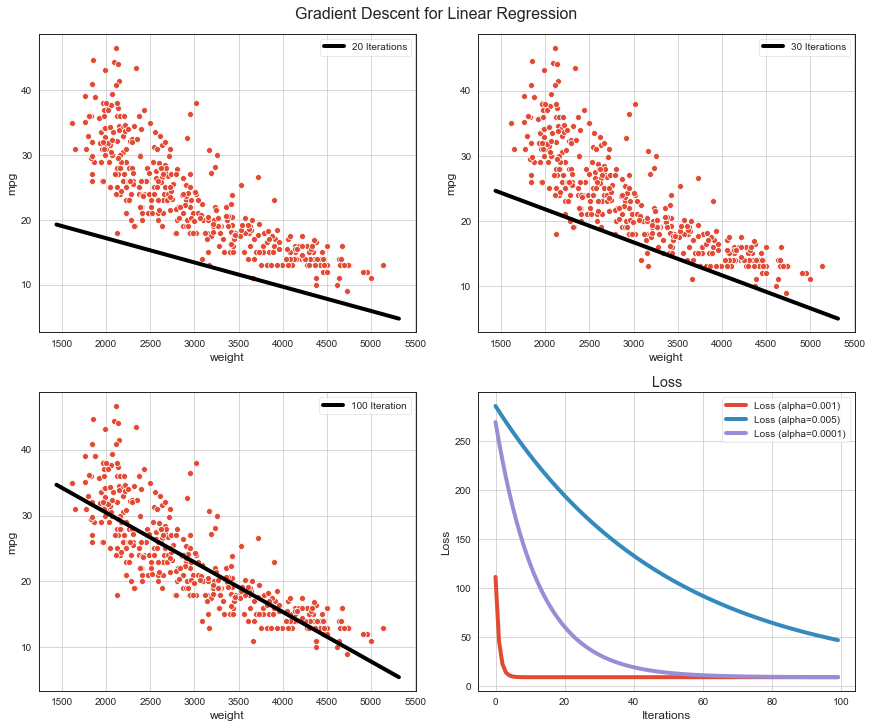

In [78]:
# plot regressions and losses

def abline(ax, slope, intercept, scaler=None, c='black', lw=4, label=''):
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * (x_vals if scaler is None else scaler.transform(x_vals.reshape(-1, 1)).reshape(1, -1))
    ax.plot(x_vals, y_vals.reshape(-1), '-', c=c, lw=lw, label=label)

def inverse_transform(x, mu, s):
    return x * s + mu

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 10), constrained_layout=True)
fig.suptitle('Gradient Descent for Linear Regression', fontsize=16)
sns.scatterplot(x='weight', y='mpg', data=df, ax=ax[0][0]);
sns.scatterplot(x='weight', y='mpg', data=df, ax=ax[0][1]);
sns.scatterplot(x='weight', y='mpg', data=df, ax=ax[1][0]);

abline(ax[0][0], ws[19][1], ws[19][0], scaler=sx, lw=4, label='20 Iterations')
abline(ax[0][1], ws[29][1], ws[29][0], scaler=sx, lw=4, label='30 Iterations')
abline(ax[1][0], ws[99][1], ws[99][0], scaler=sx, lw=4, label='100 Iteration')

for a in range(len(alphas)):
    ax[1][1].plot(range(iters), losses[a], lw=4, label=f'Loss (alpha={alphas[a]})');
ax[1][1].set_title('Loss');
ax[1][1].set_xlabel('Iterations');
ax[1][1].set_ylabel('Loss');

for i in range(len(ax)):
    for j in range(len(ax[i])):
        ax[i][j].grid()
        ax[i][j].legend()

## Optimizers

### Stochastic Gradient Descent

Calculating gradient from loss function requires us averaging over all instances in the training dataset which could be billions of rows.

*Mini-batch Gradient Descent* takes mini-batches (usually of sizes 1 to few hundred) of training instances to calculate gradient and update weights. This way, gradient descent algorithm scales to massive datasets. It will only approximate GD algorithm.

*Stochastic gradient descent* takes mini-batches of size 1.

<table><tr>
    <td><img width="400" src="http://cs231n.github.io/assets/nn3/opt2.gif" /></td>
    <td><img width="400" src="http://cs231n.github.io/assets/nn3/opt1.gif" /></td>
</tr></table>

[Alec Radford](https://twitter.com/alecrad), [Stanford Course - cs231n](http://cs231n.github.io/neural-networks-3/)

## Linear and Non-Linear Problems

Decision boundary of linear models is a hyperplane. It cannot classify or regress reliably when instances have more complex behaviour.

<table><tr>
    <td><img src="https://developers.google.com/machine-learning/crash-course/images/LinearProblem1.png" /></td>
    <td><img src="https://developers.google.com/machine-learning/crash-course/images/LinearProblemNot.png" /></td>
</tr></table>

<div style="float: left;">
    <h3>Feature Crosses & Polynomials</h3>

One way to solve nonlinear problem is to create a *feature cross* or *feature polynomial*. 

1. Feature cross encodes nonlinearity by multiplying two or more features. Eg. $x_3 = x_1x_2$.
1. Feature polynomial encodes nonlinearity by taking polynomial of feature. Eg. $x_4 = x_1^2$.

Another way is to use neural nets.
</div>
<div style="float: right;"><img width="300" src="./imlp4_files/cross.png" /></div>

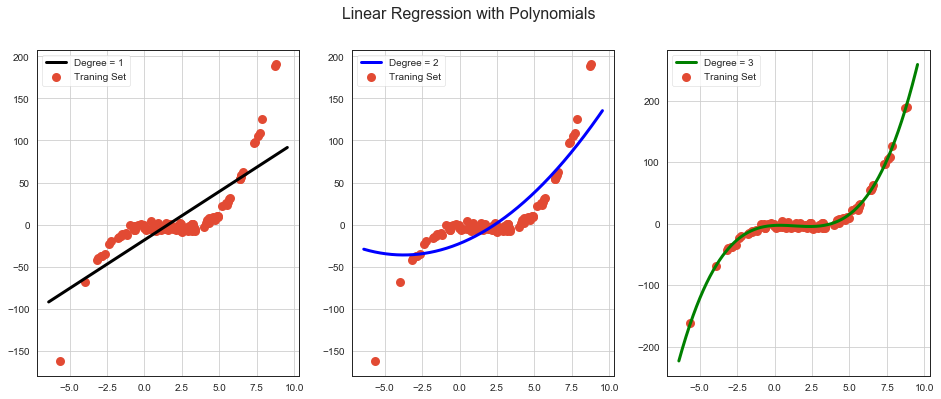

In [302]:
# higher-order polynomials in linear regression
from sklearn.preprocessing import PolynomialFeatures

N = 100
np.random.seed(0)
x = 2 + 3 * np.random.normal(0, 1, N)
y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + np.random.normal(-3, 3, N)

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle('Linear Regression with Polynomials', fontsize=16)
ax[0].scatter(x, y, lw=3, label='Traning Set')
ax[1].scatter(x, y, lw=3, label='Traning Set')
ax[2].scatter(x, y, lw=3, label='Traning Set')
x_lim = ax[0].get_xlim()

lr = LinearRegression()
lr.fit(x.reshape(-1, 1), y)
abline(ax[0], lr.coef_[0], lr.intercept_, lw=3, c='k', label='Degree = 1')

lr = LinearRegression()
pf = PolynomialFeatures(degree=2)
x_poly = pf.fit_transform(x.reshape(-1, 1))
lr.fit(x_poly, y)
xs = np.linspace(x_lim[0], x_lim[1], 1000)
ax[1].plot(xs, lr.predict(pf.transform(xs.reshape(-1, 1))), lw=3, c='b', label='Degree = 2')

lr = LinearRegression()
pf = PolynomialFeatures(degree=3)
x_poly = pf.fit_transform(x.reshape(-1, 1))
lr.fit(x_poly, y)
xs = np.linspace(x_lim[0], x_lim[1], 1000)
ax[2].plot(xs, lr.predict(pf.transform(xs.reshape(-1, 1))), lw=3, c='g', label='Degree = 3')

for i in range(len(ax)):
    ax[i].legend();
    ax[i].grid();

## Neural Networks

### Layers

We can represent linear model as input layery with output layer. Each blue circle represents one feature value, output unit computes weighted sum of the inputs.

<img width="300" src="./imlp4_files/linear_model.png" />

To improve model ability to solve nonlinear problems, we can add hidden layer or layers. Each yellow unit in hidden layer is a weighted sum of the blue input unit values.

This is stil calculating linear combination of inputs thus it is still linear model.

<img width="500" src="./imlp4_files/hidden_layers1.png" />

### Activation Functions

To model a nonlinear problem, we can directly introduce a nonlinearity. We can pipe each hidden layer node through a nonlinear function.

Wanted properties of activation functions:

1. Differentiable for all values.
1. Fast to compute.
1. Non-zero derivatives.

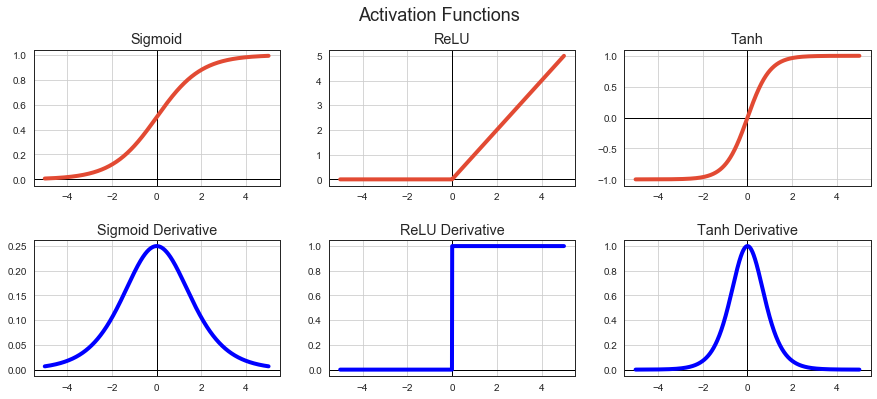

In [250]:
# activation functions
def sigmoid(s):
    return 1 / (1 + np.exp(-s))

def sigmoid_grad(s):
    return sigmoid(s) * (1 - sigmoid(s))

def relu(s):
    return np.maximum(0, s)

def relu_grad(s):
    return np.where(s >= 0, 1, 0)

def tanh(s):
    return np.tanh(s)

def tanh_grad(s):
    return 1 - np.power(tanh(s), 2)

N = 1000
s = np.linspace(-5, 5, N)

fig, axx = plt.subplots(2,3, figsize = (15,6))
fig.suptitle('Activation Functions', fontsize=18)
fig.subplots_adjust(hspace=.4)
for i in range(len(axx)):
    for j in range(len(axx[i])):
        ax = axx[i][j]
        ax.axhline(0, -5, 5, c='k', lw=1)
        ax.axvline(0, 0, 1, c='k', lw=1)
        ax.grid()
    
ax = axx[0][0]
ax.plot(s, sigmoid(s), label='Sigmoid Activation', lw=4)
ax.set_title('Sigmoid')

ax = axx[0][1]
ax.plot(s, relu(s), label='ReLU Activation', lw=4)
ax.set_title('ReLU')

ax = axx[0][2]
ax.plot(s, tanh(s), label='Tanh Activation', lw=4)
ax.set_title('Tanh')

ax = axx[1][0]
ax.plot(s, sigmoid_grad(s), label='Sigmoid Derivative', lw=4, c='b')
ax.set_title('Sigmoid Derivative')

ax = axx[1][1]
ax.plot(s, relu_grad(s), label='ReLU Derivative', lw=4, c='b')
ax.set_title('ReLU Derivative')

ax = axx[1][2]
ax.plot(s, tanh_grad(s), label='Tanh Derivative', lw=4, c='b')
ax.set_title('Tanh Derivative');

<a id="tf"></a>

# TensorFlow

## Linear Regression

In [80]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

In [393]:
df = pd.read_csv('./imlp4_files/auto-mpg.csv')

x_train = sx.transform(df['weight'].values.reshape(-1, 1))
y_train = df['mpg'].values
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=.2)

print(f'Data shapes: {x_train.shape}, {y_train.shape}')

Data shapes: (318, 1), (318,)


In [394]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1, activation=None, input_shape=[1]),
])

model.compile(optimizer='sgd',
              loss='mse',
              metrics=['mse'])

### Training

1. Keeping 20% out of training dataset as validation dataset.
1. Batch - number of instances to calculate gradient from in a single iteration.
1. Epoch - how many times the training algorithm sees complete training dataset.

In [403]:
model.fit(x_train, y_train, validation_split=.2, epochs=3, batch_size=16);

Train on 254 samples, validate on 64 samples
Epoch 1/3
254/254 [==============================] - 0s 196us/sample - loss: 20.2035 - mse: 20.2035 - val_loss: 16.5460 - val_mse: 16.5460
Epoch 2/3
254/254 [==============================] - 0s 158us/sample - loss: 20.2002 - mse: 20.2002 - val_loss: 16.5661 - val_mse: 16.5661
Epoch 3/3
254/254 [==============================] - 0s 156us/sample - loss: 20.1769 - mse: 20.1769 - val_loss: 16.5675 - val_mse: 16.5675


In [404]:
print(f'MSE on testing dataset: {model.evaluate(x_test, y_test, verbose=0)[0]:.5}')

MSE on testing dataset: 16.9


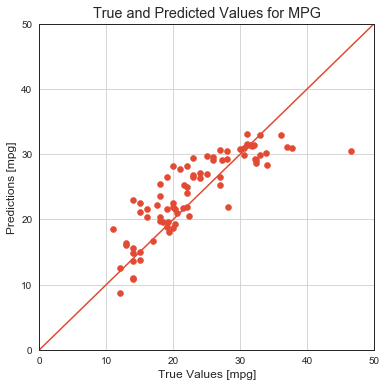

In [405]:
# scatter for predicted vs true values
fig = plt.figure(figsize=(6, 6))
plt.scatter(y_test, model.predict(x_test).flatten())
plt.xlabel('True Values [mpg]')
plt.ylabel('Predictions [mpg]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)
plt.grid()
plt.title('True and Predicted Values for MPG');

## Image Classification of MNIST Dataset

In [408]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

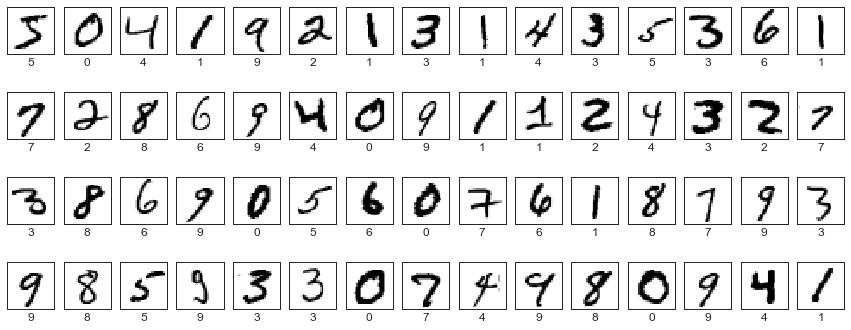

In [409]:
# handwritten digits
plt.figure(figsize=(15,6))
for i in range(15*4):
    plt.subplot(4,15,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])

In [411]:
x_train, x_test = x_train / 255.0, x_test / 255.0

print(f'Data shapes: {x_train.shape}, {y_train.shape}')

Data shapes: (60000, 28, 28), (60000,)


### Dataset

Dataset API enables us to build complex input pipelines from simple, reusable pieces and allows TensorFlow programs to scale training data beyond RAM capacity.

### TFRecord and Example



In [412]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(128)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [413]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Activation Functions for Classification

#### Sigmoid

Sigmoid squashes input in the range $(0, 1)$ that can be interpreted as probability of positive class.

$$ f(s_i) = \frac{1}{1 + e^{-s_i}} $$

#### Softmax

Softmax squashes input in the range $(0,1)$ in a way that all the resulting elements add up to 1. Itis applied to the output scores $s$. Outputs can be interpretted as class probabilities.

$$ f(s)_i = \frac{e^{s_i}}{\sum_j^C e^{s_j}} $$

### Loss Functions Classification

#### Cross-Entropy Loss

$$ \text{CE} = -\sum_i^Ct_i\log(s_i) $$

Where $t_i$ are groundtruth labels and $s_i$ are NN scores for each class $i$ in $C$.

#### Binary Classification

In a binary classification problem where $C = 2$, the cross-entropy loss can be defined also as:

<img width="600" src="./imlp4_files/sigmoid.png" />

$$ \text{CE} = -\sum_i^Ct_i\log(s_i) = - t_1\log(s_1) + (1-t_1)\log(1-s_1) $$

This log loss function is also called *binary cross-entropy loss*.

#### Multiclass Classification

Classification of instances into more than 2 classes when one instance could be in one class only is called *multiclass classification*. Compare with *multilabel classification* when one instance could be in more than one class.

We use softmax activation plus a cross-entropy loss. 

<img width="600" src="./imlp4_files/softmax.png" />

$$ f(s)_i = \frac{e^{s_i}}{\sum_j^C e^{s_j}} \ \ \text{CE} = -\sum_i^Ct_i\log(f(s)_i) = -\log\frac{e^{s_p}}{\sum_j^C e^{s_j}} $$

In [430]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [431]:
model.fit(train_ds, validation_data=val_ds, epochs=20);

Epoch 1/20
375/375 [==============================] - 4s 11ms/step - loss: 1.1014 - accuracy: 0.6696 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
375/375 [==============================] - 3s 7ms/step - loss: 0.4430 - accuracy: 0.8703 - val_loss: 0.3587 - val_accuracy: 0.9000
Epoch 3/20
375/375 [==============================] - 3s 8ms/step - loss: 0.3533 - accuracy: 0.8950 - val_loss: 0.3244 - val_accuracy: 0.9062
Epoch 4/20
375/375 [==============================] - 3s 7ms/step - loss: 0.3134 - accuracy: 0.9080 - val_loss: 0.2888 - val_accuracy: 0.9179
Epoch 5/20
375/375 [==============================] - 3s 7ms/step - loss: 0.2835 - accuracy: 0.9170 - val_loss: 0.2706 - val_accuracy: 0.9216
Epoch 6/20
375/375 [==============================] - 3s 8ms/step - loss: 0.2598 - accuracy: 0.9229 - val_loss: 0.2499 - val_accuracy: 0.9262
Epoch 7/20
375/375 [==============================] - 3s 7ms/step - loss: 0.2372 - accuracy: 0.9299 - val_loss: 0.2318 - val_accuracy: 0.93

In [429]:
loss, accuracy = model.evaluate(test_ds)
print(f'Loss: {loss:.3f}, accuracy: {accuracy:.3f}')

313/313 [==============================] - 0s 1ms/step - loss: 0.1867 - accuracy: 0.9442
Loss: 0.187, accuracy: 0.944


### Regularization

#### Simplicity

Loss function in linear regression with penalty equivalent to square of the magnitude of the coefficients is called *Ridge regression*. This type or regularization is called $L_2$. Ridge regression shrinks the coefficients and it helps to reduce the model complexity defined as $\lambda\sum_{j=0}^{p}w_j^2$. Small weights have small impact on model complexity, while outlier weights have big impact.

$$ \text{MSE} = \frac{1}{N} \sum_{i = 1}^{M}\left(y_i - \sum_{j=0}^{p}w_jx_{ij}\right)^2 + \lambda\sum_{j=0}^{p}w_j^2 $$

#### Sparsity

Loss function in linear regression with penalty equivalent to the magnitude of the coefficients is called *Lasso regression*. This type or regularization is called $L_1$. Lasso regression can zero-out some coefficients and it helps to reduce the model complexity defined as $\lambda\sum_{j=0}^{p}|w_j|$. Reduces over-fitting and can help with feature selection.

$$ \text{MSE} = \frac{1}{N} \sum_{i = 1}^{M}\left(y_i - \sum_{j=0}^{p}w_jx_{ij}\right)^2 + \lambda\sum_{j=0}^{p}|w_j| $$

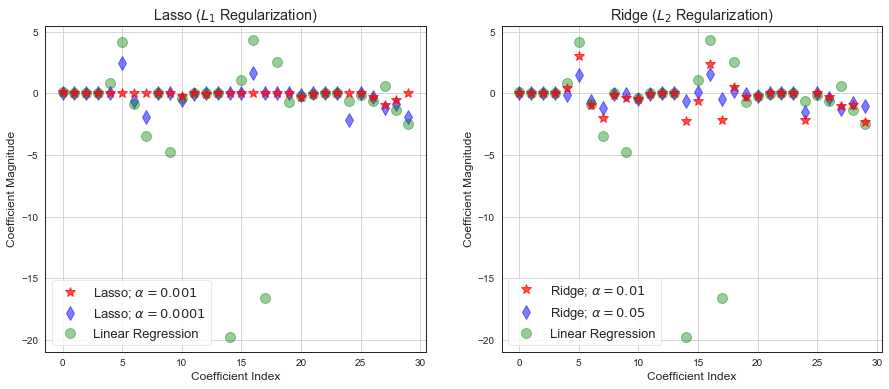

In [392]:
# Comparing L1 and L2 regularization 

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso

cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)

Y = cancer.target
X = df

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=3)

lr = LinearRegression()
lr.fit(x_train, y_train)

rr = Ridge(alpha=0.01) 
rr.fit(x_train, y_train)

rr100 = Ridge(alpha=.05)
rr100.fit(x_train, y_train)

lasso01 = Lasso(alpha=0.001)
lasso01.fit(x_train, y_train)

lasso0001 = Lasso(alpha=0.0001)
lasso0001.fit(x_train, y_train)

fig, axx = plt.subplots(1, 2, figsize=(15, 6))
ax = axx[0]
ax.plot(lasso01.coef_, alpha=0.7, linestyle='none', marker='*', markersize=10, color='red', label=r'Lasso; $\alpha = 0.001$', zorder=7)
ax.plot(lasso0001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=10,color='blue',label=r'Lasso; $\alpha = 0.0001$')
ax.plot(lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=10,color='green',label='Linear Regression')
ax.set_xlabel('Coefficient Index')
ax.set_ylabel('Coefficient Magnitude')
ax.legend(fontsize=13,loc=3)
ax.set_title(r'Lasso ($L_1$ Regularization)')
ax.grid()

ax = axx[1]
ax.plot(rr.coef_, alpha=0.7, linestyle='none', marker='*', markersize=10, color='red', label=r'Ridge; $\alpha = 0.01$', zorder=7)
ax.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=10,color='blue',label=r'Ridge; $\alpha = 0.05$')
ax.plot(lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=10,color='green',label='Linear Regression')
ax.set_xlabel('Coefficient Index')
ax.set_ylabel('Coefficient Magnitude')
ax.legend(fontsize=13,loc=3)
ax.grid()
ax.set_title(r'Ridge ($L_2$ Regularization)');

[Link](https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b)

#### Bias, Variance, Regularization

1. OLS (ordinary least squares give unbiased result but it is not very consistent.
1. Ridge gives a small bias but more consistent predictions.
2. Lasso gives a high bias but low variance.

<img src="https://miro.medium.com/max/1440/1*CQwtseFFbteSLy-qKmq8qQ.png" />

[Link](https://towardsdatascience.com/bias-and-variance-in-linear-models-e772546e0c30)

### Dropout 

We can train 5 NN on the same training data giving 5 different result we average to get final prediction. Dropout is doing this with less costly way. Or it reduces complex co-adaptations of neurons and forces them to learn more robust features as if we were removing or losing piece of evidence.

Dropout prevents overfitting and increases robustness of the model and removes any simple dependencies between the neurons by randomly turning neurons off in the training step.

1. Dropout forces a neural network to learn more robust features that are useful in conjunction with many different random subsets of the other neurons.
1. Dropout roughly doubles the number of iterations required to converge. However, training time for each epoch is less.
1. With H hidden units, each of which can be dropped, we have
2^H possible models. In testing phase, the entire network is considered and each activation is reduced by a factor p.

[Link](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5)
[Link](http://neuralnetworksanddeeplearning.com/chap3.html)

<img width="600" src="https://miro.medium.com/max/2088/1*iWQzxhVlvadk6VAJjsgXgg.png" />

[Srivastava, Nitish, et al. ”Dropout: a simple way to prevent neural networks from
overfitting”, JMLR 2014](http://jmlr.org/papers/v15/srivastava14a.html)

## Training with Structured Data

We load our weather dataset and preprocess it in the same way as we did in the 2nd lesson. Preprocessing it as a part of tensorflow model is over-kill, we need some other way for preprocessing like sklearn, Hive, spark, ...

In [433]:
# Read data from local .csv file and do basic preprocessing that makes sense to do everywhere
df = pd.read_csv('weatherAUS.csv')
df['RainToday'] = df['RainToday'].replace({'Yes': 1, 'No': 0})
df['RainTomorrow'] = df['RainTomorrow'].replace({'Yes': 1, 'No': 0})
df['DateD'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df['RainTodayD'] = df['RainToday'].map(lambda l: 1 if l == 'Yes' else 0)
df['Year'] = df['DateD'].dt.year
df['Month'] = df['DateD'].dt.month
df['YearMonth'] = df[['Year', 'Month']].apply(lambda r: f'{r[0]}-{r[1]:02d}', axis=1)

# Calculate rolling features that are hard to do in production but we check their importance here
def agg_days_since_rain(x):
    x = x[:-1]
    r = np.argmax(np.flip(x)) + 1 if x.any() else 20
    return r

def agg_rain_days(x):
    return np.sum(x[:-1])

def rolling_feature(d, by, on, val, window, name, agg_fce):
    cs = [by, on]
    r = d.sort_values(cs).groupby(by).rolling(window, on=on, min_periods=1)
    
    agg = r.apply(agg_fce, raw=True)
    agg[name] = agg[val] # agg has aggregated values in column val
    agg.drop([val, on], axis=1, inplace=True)
    agg.rename_axis(index=(by, 'Id'), inplace=True)
    agg.reset_index(inplace=True)
    return agg

# rolling_feature is custom rolling window function that takes different aggregation functions
dsrw = rolling_feature(df[['DateD', 'Location', 'RainToday']], 'Location', 'DateD', 'RainToday', 8, 'DaysSinceRainWeek', agg_days_since_rain)
rdw = rolling_feature(df[['DateD', 'Location', 'RainToday']], 'Location', 'DateD', 'RainToday', 8, 'RainDaysWeek', agg_rain_days)

# prepare original dataset to have the same index as rv
d = df.copy()
d.set_index(['Location'], append=True, inplace=True)
d.rename_axis(('Id', 'Location'), inplace=True)
d.reset_index(inplace=True)

# merge new features and drop technical columns
d = d.merge(dsrw, on=['Id', 'Location'])
d = d.merge(rdw, on=['Id', 'Location'])

d['NoRainWeek'] = d['DaysSinceRainWeek'].map(lambda l: 1 if l == 20 else 0)
d['DaysSinceRainWeek'] = d['DaysSinceRainWeek'].replace({20: 0})

df = d

from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.pipeline import make_pipeline as mp

features = []

ff = ['Cloud9am', 'Cloud3pm']
features += [('~indicator1', SimpleImputer(strategy='mean', add_indicator=True), ff)]

# mean for features with no outliers
ff = ['Temp3pm', 'Temp9am', 'Pressure9am', 'Pressure3pm', 'MinTemp', 'MaxTemp', 
      'Humidity9am', 'Humidity3pm']
features += [(f, SimpleImputer(strategy='mean'), [f]) for f in ff]

# median for features with outliers
ff = ['Evaporation', 'Sunshine']
features += [('~indicator2', SimpleImputer(strategy='median', add_indicator=True), ff)]

# median for kind of categorical vars
ff = ['RainDaysWeek', 'DaysSinceRainWeek']
features += [(f, SimpleImputer(strategy='median'), [f]) for f in ff]

# 0 (zero) where it is a meaningful value
ff = ['RainToday', 'NoRainWeek']
features += [(f, SimpleImputer(strategy='constant', fill_value=0), [f]) for f in ff]

# we use log(x+1) to fix distributions
ff = ['Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']
features += [(f, mp(SimpleImputer(strategy='median'), FunctionTransformer(np.log1p)), [f]) for f in ff]

# we use 2 features to create a new one
def gt0(a):
    a[a > 0] = 1
    a[a <= 0] = 0
    return a

ff = ['Pressure3pm', 'Pressure9am']
features += [('-PressureDiff', mp(SimpleImputer(strategy='mean'), 
                                  FunctionTransformer(np.diff)), ff)]
features += [('-PressureDrop', mp(SimpleImputer(strategy='mean'), 
                                  FunctionTransformer(np.diff), 
                                  FunctionTransformer(gt0)), ff)]

# we generate one hot encodings for categorical features
ff = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
features += [(f, SimpleImputer(strategy='most_frequent'), [f]) for f in ff]

ff = ['Location', 'Month', 'YearMonth']
features += [(f, 'passthrough', [f]) for f in ff]

In [434]:
# transformation in sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Little magic to get to meaningful feature names after ColumnTransformer step.

def get_feature_names(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        tn = transformer_in_columns[0]
        
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
            
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
            
        if isinstance(names,np.ndarray) or isinstance(names,list):
            if isinstance(transformer, OneHotEncoder):
                col_name += [f'{tn}_{n.replace("x0_", "")}' if 'x0_' in n else n for n in names]
            elif '~' in tn:
                col_name += names
                col_name += [f'{n}{tn}' for n in names]
            elif '-' in tn:
                col_name += [tn[1:]]
            else:
                col_name += names
        elif isinstance(names,str):
            col_name.append(names)
            
    return col_name
                             
ct = ColumnTransformer(features)
vals = ct.fit_transform(df)
fs = get_feature_names(ct)
trans_df = pd.DataFrame(vals, columns=[f.replace('~', '_') for f in fs])
trans_df['RainTomorrow'] = df['RainTomorrow']

In [435]:
# features
from sklearn.model_selection import train_test_split

dd = trans_df[['Cloud9am', 'Cloud3pm', 'Cloud9am_indicator1', 'Cloud3pm_indicator1',
       'Temp3pm', 'Temp9am', 'Pressure9am', 'Pressure3pm', 'MinTemp',
       'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Evaporation', 'Sunshine',
       'Evaporation_indicator2', 'Sunshine_indicator2', 'RainDaysWeek',
       'DaysSinceRainWeek', 'RainToday', 'NoRainWeek', 'Rainfall',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'PressureDiff',
       'PressureDrop', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Location',
       'Month', 'YearMonth', 'RainTomorrow']].dropna()

dd.head()

,Cloud9am,Cloud3pm,Cloud9am_indicator1,Cloud3pm_indicator1,Temp3pm,Temp9am,Pressure9am,Pressure3pm,MinTemp,MaxTemp,...,WindSpeed3pm,PressureDiff,PressureDrop,WindGustDir,WindDir9am,WindDir3pm,Location,Month,YearMonth,RainTomorrow
0,8,4.50317,0,1,21.8,16.9,1007.7,1007.1,13.4,22.9,...,3.21888,0.6,1,W,W,WNW,Albury,12,2008-12,0
1,4.43719,4.50317,1,1,24.3,17.2,1010.6,1007.8,7.4,25.1,...,3.13549,2.8,1,WNW,NNW,WSW,Albury,12,2008-12,0
2,4.43719,2,1,0,23.2,21,1007.6,1008.7,12.9,25.7,...,3.29584,-1.1,0,WSW,W,WSW,Albury,12,2008-12,0
3,4.43719,4.50317,1,1,26.5,18.1,1017.6,1012.8,9.2,28,...,2.30259,4.8,1,NE,SE,E,Albury,12,2008-12,0
4,7,8,0,0,29.7,17.8,1010.8,1006,17.5,32.3,...,3.04452,4.8,1,W,ENE,NW,Albury,12,2008-12,0


We split into training, validation, testing data.

In [436]:
train, test = train_test_split(dd, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

91003 train examples
22751 validation examples
28439 test examples


In [437]:
def df_to_dataset(dataframe, label, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop(label)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

We convert training, validation, testing data to Datasets.

In [438]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, 'RainTomorrow', batch_size=batch_size)
val_ds = df_to_dataset(val, 'RainTomorrow', shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, 'RainTomorrow', shuffle=False, batch_size=batch_size)

Examples of data.

In [439]:
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of locations:', feature_batch['Location'])
    print('A batch of targets:', label_batch )

Every feature: ['Cloud9am', 'Cloud3pm', 'Cloud9am_indicator1', 'Cloud3pm_indicator1', 'Temp3pm', 'Temp9am', 'Pressure9am', 'Pressure3pm', 'MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Evaporation', 'Sunshine', 'Evaporation_indicator2', 'Sunshine_indicator2', 'RainDaysWeek', 'DaysSinceRainWeek', 'RainToday', 'NoRainWeek', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'PressureDiff', 'PressureDrop', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Location', 'Month', 'YearMonth']
A batch of locations: tf.Tensor([b'SalmonGums' b'NorahHead' b'Williamtown' b'MountGambier' b'Hobart'], shape=(5,), dtype=string)
A batch of targets: tf.Tensor([0 1 0 0 0], shape=(5,), dtype=int32)


In [440]:
example_batch = next(iter(train_ds))[0]

In [441]:
def demo(feature_column):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch).numpy())

In [442]:
trans_df.columns

Index(['Cloud9am', 'Cloud3pm', 'Cloud9am_indicator1', 'Cloud3pm_indicator1',
       'Temp3pm', 'Temp9am', 'Pressure9am', 'Pressure3pm', 'MinTemp',
       'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Evaporation', 'Sunshine',
       'Evaporation_indicator2', 'Sunshine_indicator2', 'RainDaysWeek',
       'DaysSinceRainWeek', 'RainToday', 'NoRainWeek', 'Rainfall',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'PressureDiff',
       'PressureDrop', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Location',
       'Month', 'YearMonth', 'RainTomorrow'],
      dtype='object')

### Feature Columns

We prepare input layer of our neural net using [tensorflow.feature_column] which defines mapping from strucured data to input layer.

#### Numeric columns

In [443]:
numeric_features = ['Cloud9am', 'Cloud3pm', 'Cloud9am_indicator1', 'Cloud3pm_indicator1',
       'Temp3pm', 'Temp9am', 'Pressure9am', 'Pressure3pm', 'MinTemp',
       'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Evaporation', 'Sunshine',
       'Evaporation_indicator2', 'Sunshine_indicator2', 'RainDaysWeek',
       'DaysSinceRainWeek', 'RainToday', 'NoRainWeek', 'Rainfall',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'PressureDiff',
       'PressureDrop']

In [444]:
from tensorflow import feature_column as fc
numeric_columns = [fc.numeric_column(c) for c in numeric_features]

#### Categorical Columns

First, create a mapping from strings to indexes (numbers) using some dictionary.

In [445]:
categorical_columns = [
    fc.categorical_column_with_vocabulary_list('Month', dd['Month'].unique().astype(np.int32)),
    fc.categorical_column_with_vocabulary_list('YearMonth', dd['YearMonth'].unique()),
    fc.categorical_column_with_vocabulary_list('WindGustDir', dd['WindGustDir'].unique()),    
]

One-hot encode indexes.

In [446]:
categorical_columns = [fc.indicator_column(c) for c in categorical_columns]

#### Feature Crossees

In [459]:
wind_dir_9am = fc.categorical_column_with_vocabulary_list('WindDir9am', dd['WindDir9am'].unique())
wind_dir_3pm = fc.categorical_column_with_vocabulary_list('WindDir3pm', dd['WindDir3pm'].unique())

wind_dir_cross = fc.crossed_column([wind_dir_9am, wind_dir_3pm], 50)

In [460]:
wind_dir_9am = fc.indicator_column(wind_dir_9am)
wind_dir_3pm = fc.indicator_column(wind_dir_3pm)

### Embeddings

We encode categorical data as one-hot encodings. If categorical feature has high cardinality, these ohe vectors are very sparse. This is a problem to the network as it has much more connections from input layer and have to train them.

1. The more parameters, the more weights, the more data for training.
1. The more weights the mode time for training and inference.

Embeddings translate large sparse vectors into a lower-dimensional space that preserves semantic relationships.

![embeddings](https://developers.google.com/machine-learning/crash-course/images/linear-relationships.svg)

Embeddings as lookup tables.

An embedding matrix is a matrix in which each column is the vector that corresponds to an item in your vocabulary.

If the sparse vector contains counts of the vocabulary items, you could multiply each embedding by the count of its corresponding item before adding it to the sum.

Given a 1 X N sparse representation S and an N X M embedding table E, the matrix multiplication S X E gives you the 1 X M dense vector.

Training an Embedding as Part of a Larger Model.

You can also learn an embedding as part of the neural network for your target task. This approach gets you an embedding well customized for your particular system, but may take longer than training the embedding separately

![train embedding](https://developers.google.com/machine-learning/crash-course/images/dnn-to-geometric-view.svg)

In [461]:
wind_dir = fc.embedding_column(wind_dir_cross, dimension=4)

In [462]:
location = fc.embedding_column(
    fc.categorical_column_with_vocabulary_list('Location', dd['Location'].unique()),
    dimension=4)

In [463]:
feature_columns = numeric_columns + categorical_columns + [location, wind_dir_3pm, wind_dir_9am, wind_dir]

batch_size = 32
train_ds = df_to_dataset(train, 'RainTomorrow', batch_size=batch_size)
val_ds = df_to_dataset(val, 'RainTomorrow', shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, 'RainTomorrow', shuffle=False, batch_size=batch_size)

In [464]:
%load_ext tensorboard
!rm -rf ./logs/ 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [465]:
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime

In [466]:
# we define binary classification metrics
metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),   
    keras.metrics.
]

In [467]:
# model structure
model = tf.keras.Sequential([
    tf.keras.layers.DenseFeatures(feature_columns),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics)

In [468]:
log_dir="./logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [469]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=5,
          callbacks=[tensorboard_callback]);

Epoch 1/5
2844/2844 [==============================] - 31s 11ms/step - loss: 0.9620 - tp: 9130.0000 - fp: 9711.0000 - tn: 60888.0000 - fn: 11274.0000 - accuracy: 0.7694 - precision: 0.4846 - recall: 0.4475 - auc: 0.7258 - val_loss: 0.0000e+00 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 2/5
2844/2844 [==============================] - 16s 6ms/step - loss: 0.4786 - tp: 9448.0000 - fp: 6667.0000 - tn: 63932.0000 - fn: 10956.0000 - accuracy: 0.8063 - precision: 0.5863 - recall: 0.4630 - auc: 0.7908 - val_loss: 0.4332 - val_tp: 1303.0000 - val_fp: 221.0000 - val_tn: 17407.0000 - val_fn: 3820.0000 - val_accuracy: 0.8224 - val_precision: 0.8550 - val_recall: 0.2543 - val_auc: 0.8519
Epoch 3/5
2844/2844 [==============================] - 17s 6ms/step - loss: 0.3998 - tp: 9437.0000 - fp: 4791.0000 - tn: 65808.0000 - fn: 10967.0000 - accuracy: 0.8268

In [470]:
%tensorboard --logdir logs/fit

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 85831.

In [471]:
metrics = model.evaluate(test_ds)

print(f'Accuracy: {metrics[5]:.2},\nPrecision: {metrics[6]:.2},\nRecall: {metrics[7]:.2}')

889/889 [==============================] - 3s 3ms/step - loss: 0.3871 - tp: 3403.0000 - fp: 1847.0000 - tn: 20242.0000 - fn: 2947.0000 - accuracy: 0.8314 - precision: 0.6482 - recall: 0.5359 - auc: 0.8457
Accuracy: 0.83,
Precision: 0.65,
Recall: 0.54


## Resources

1. **John D. Kelleher et al.** [Fundamentals of Machine Learning for Predicitve Data Analytics](https://www.amazon.com/Fundamentals-Machine-Learning-Predictive-Analytics/dp/0262029448/ref=sr_1_1?keywords=machine+learning+for+predictive+data+analytics&qid=1569507170&sr=8-1)
2. **Sebastian Raschka** [Python Machine Learning](https://www.amazon.com/Python-Machine-Learning-Sebastian-Raschka-ebook/dp/B00YSILNL0)
3. **Ian Goodfellow et al.** [Deep Learning](https://www.amazon.com/Deep-Learning-Adaptive-Computation-Machine/dp/0262035618/ref=sr_1_1?crid=1H65RO9KWHYRL&keywords=goodfellow+deep+learning&qid=1572383007&sprefix=goodfellow+deep%2Caps%2C258&sr=8-1)
4. **Christopher Olah** [Neural Networks, Manifolds, and Topology](http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/)
5. [Google - Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course)
6. **Raul Gomez** [Understanding Categorical Cross-Entropy Loss, Binary Cross-Entropy Loss, ...](https://gombru.github.io/2018/05/23/cross_entropy_loss/)